# Data Collection & Characteristics

There are three types of sensor data:

\begin{enumerate}
\item Air Temperature: Air temperature data is collected in celsius degree
\item Relative Humidity: Relative humidity is collected in percentage
\item Soil Moisture: Three soil moisture sensors are collecting data are connected to the micro-controller board and collected  at 3 different spots respectively. However, readings from soil moisture sensor are not in meaningful unit.
\end{enumerate}

All sensors write data to the micro SD card every 30 seconds for 24 hours a day & 7 days a week. Dual batteries can support the entire set working for over 12 hours and batteries are replaced twice a day.

Sensor data is collected approximately every 24 hours. However, sensors experience temporary power outage (a few minutes) while transporting data from the micro SD card to computer. In addition, sensor set may also suffer from hours of power outage under the influence of some weather extremes that shorten the battery life and therefore terminate data collection before next scheduled battery replacement.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

data = pd.read_csv("RG_sensor_data.csv")
data = data.drop(['index'], axis=1)
print(len(data))
data.head()

33681


,temperature,humidity,soil_moisture_0,soil_moisture_1,soil_moisture_2
0,-2.1,69.7,318,429,268
1,-2.1,69.6,315,430,268
2,-2.1,69.6,313,431,268
3,-2.1,69.7,327,430,268
4,-2.0,69.7,328,430,268


# Data Preprocessing

The goal of data preprocessing is mainly to map a time stamp to each entry

In [2]:
from datetime import date, time, datetime, timedelta
time_step = timedelta(seconds=30)
start_collection = datetime(2019, 11, 14, 8, 9, 0, 0)
timestamp = [start_collection + time_step * i for i in data.index]
data.index = timestamp
data.head(10)

,temperature,humidity,soil_moisture_0,soil_moisture_1,soil_moisture_2
2019-11-14 08:09:00,-2.1,69.7,318,429,268
2019-11-14 08:09:30,-2.1,69.6,315,430,268
2019-11-14 08:10:00,-2.1,69.6,313,431,268
2019-11-14 08:10:30,-2.1,69.7,327,430,268
2019-11-14 08:11:00,-2.0,69.7,328,430,268
2019-11-14 08:11:30,-2.0,69.7,329,430,268
2019-11-14 08:12:00,-2.0,69.7,330,430,268
2019-11-14 08:12:30,-1.9,69.7,330,430,268
2019-11-14 08:13:00,-1.9,69.7,329,430,268
2019-11-14 08:13:30,-1.9,69.7,329,430,268


# Visualizing Raw Data

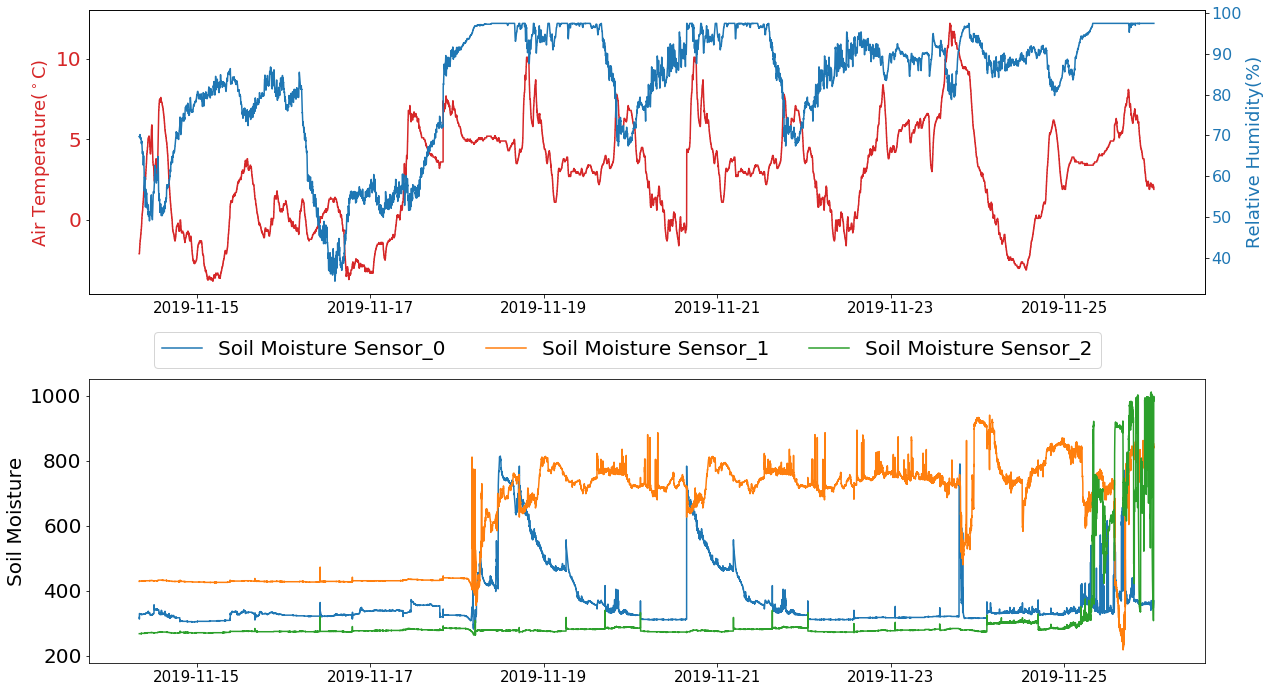

In [3]:
fig, ax = plt.subplots(2, 1, sharex= True, figsize=(20,12))

# tempearture & relative humidity plots
temp_color = 'tab:red'
ax[0].plot(data.index, data.temperature, color=temp_color)
ax[0].tick_params(labelbottom=True, labelsize=15)
ax[0].set_ylabel('Air Temperature($^\circ$C)', color=temp_color, fontsize=18)
ax[0].tick_params(axis='y', labelcolor=temp_color, labelsize=20)

humidity = ax[0].twinx()

humi_color = 'tab:blue'
humidity.plot(data.index, data.humidity, color=humi_color)
humidity.set_ylabel('Relative Humidity(%)', color=humi_color, fontsize=18)
humidity.tick_params(axis='y', labelcolor=humi_color, labelsize=16)

# soil moisture plot
ax[1].plot(data.index, data.soil_moisture_0, label='Soil Moisture Sensor_0')
ax[1].plot(data.index, data.soil_moisture_1, label='Soil Moisture Sensor_1')
ax[1].plot(data.index, data.soil_moisture_2, label='Soil Moisture Sensor_2')
ax[1].set_ylabel('Soil Moisture', fontsize=20)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].legend(fontsize=20, loc='upper left', bbox_to_anchor=(0.05,1.2), ncol=3)

plt.subplots_adjust(hspace=0.3)
plt.show()

In [4]:
fig.savefig("sensor_data.png", dpi=300)

# Investigating Auto-correlation with Respect to Temperature & Relative Humidity Signals

From the soil moisture graph, the variations are generally not significant. However, huge spikes occurred rapidly on rainy days (e.g. Nov. 18th) except soil moisture sensor 2. Since there appears to be few repeating patterns in soil moisture data, auto-correlation is done to tempearture & relative humidity data.

The data was recorded every 30 seconds and the lag points are selected as below:

| Lag Point | Value (30s) |
| --- | --- |
| 1 minute | 2 |
| 30 minutes | 60 |
| 1 hour | 120 |
| 3 hours | 360 |
| 6 hours | 720 |
| 12 hours | 1440 |
| 24 hours | 2880 |
| 48 hours | 5760 |

C:\Users\chong\Anaconda3\envs\cdi\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\chong\Anaconda3\envs\cdi\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


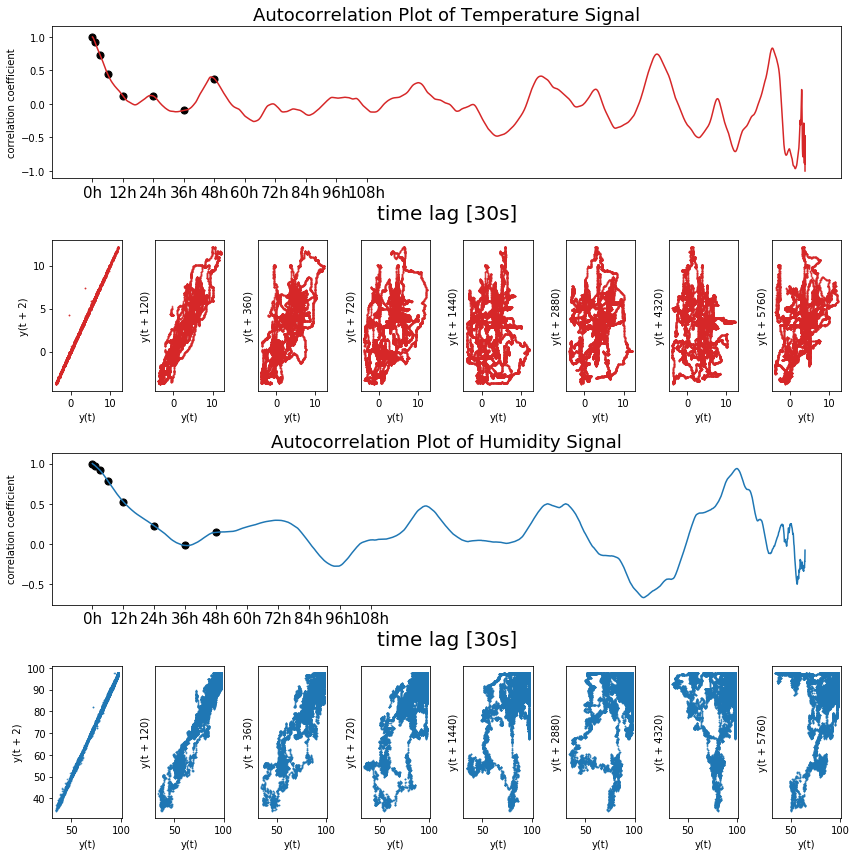

In [5]:
selectedLagPoints = [2,120,360,720,1440,2880,4320,5760]
maxLagDays = len(data)

originalSignal_temp = data['temperature']
originalSignal_humi = data['humidity']

# set grid spec of the subplots
plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4, len(selectedLagPoints))
axTopRow_temp = plt.subplot(gs[0, :])
axBottomRow_temp = []
axTopRow_humi = plt.subplot(gs[2, :])
axBottomRow_humi = []
for i in range(len(selectedLagPoints)):
    axBottomRow_temp.append(plt.subplot(gs[1, i]))
    axBottomRow_humi.append(plt.subplot(gs[3, i]))

# plot autocorr with respect to temperature & relative humidity data
allTimeLags = np.arange(1,maxLagDays)
autoCorr = [originalSignal_temp.autocorr(lag=dt) for dt in allTimeLags]
axTopRow_temp.plot(allTimeLags,autoCorr, c='tab:red')
axTopRow_temp.set_xticks([0, 1440, 2880, 4320, 5760, 7200, 8640, 10080, 11520, 12960]) 
axTopRow_temp.set_xticklabels(["0h","12h","24h", "36h", "48h","60h","72h","84h", "96h", "108h"], fontsize=15)
axTopRow_temp.set_title('Autocorrelation Plot of Temperature Signal', fontsize=18);
axTopRow_temp.set_xlabel('time lag [30s]', fontsize=20)
axTopRow_temp.set_ylabel('correlation coefficient')
selectedAutoCorr = [originalSignal_temp.autocorr(lag=dt) for dt in selectedLagPoints]
axTopRow_temp.scatter(x=selectedLagPoints, y=selectedAutoCorr, s=50, c='k')

autoCorr = [originalSignal_humi.autocorr(lag=dt) for dt in allTimeLags]
axTopRow_humi.plot(allTimeLags,autoCorr, c='tab:blue');
axTopRow_humi.set_xticks([0, 1440, 2880, 4320, 5760, 7200, 8640, 10080, 11520, 12960]) 
axTopRow_humi.set_xticklabels(["0h","12h","24h", "36h", "48h","60h","72h","84h", "96h", "108h"], fontsize=15)
axTopRow_humi.set_title('Autocorrelation Plot of Humidity Signal', fontsize=18);
axTopRow_humi.set_xlabel('time lag [30s]', fontsize=20)
axTopRow_humi.set_ylabel('correlation coefficient')
selectedAutoCorr = [originalSignal_humi.autocorr(lag=dt) for dt in selectedLagPoints]
axTopRow_humi.scatter(x=selectedLagPoints, y=selectedAutoCorr, s=50, c='k')

# plot scatter plot of selected points
for i in range(len(selectedLagPoints)):
    lag_plot(originalSignal_temp, lag=selectedLagPoints[i], s=0.5, alpha=0.7, ax=axBottomRow_temp[i], c='tab:red')
    lag_plot(originalSignal_humi, lag=selectedLagPoints[i], s=0.5, alpha=0.7, ax=axBottomRow_humi[i], c='tab:blue') 
    if i >= 1:
        axBottomRow_temp[i].set_yticks([],[])
        axBottomRow_humi[i].set_yticks([],[])
plt.tight_layout()

# Data Filtering

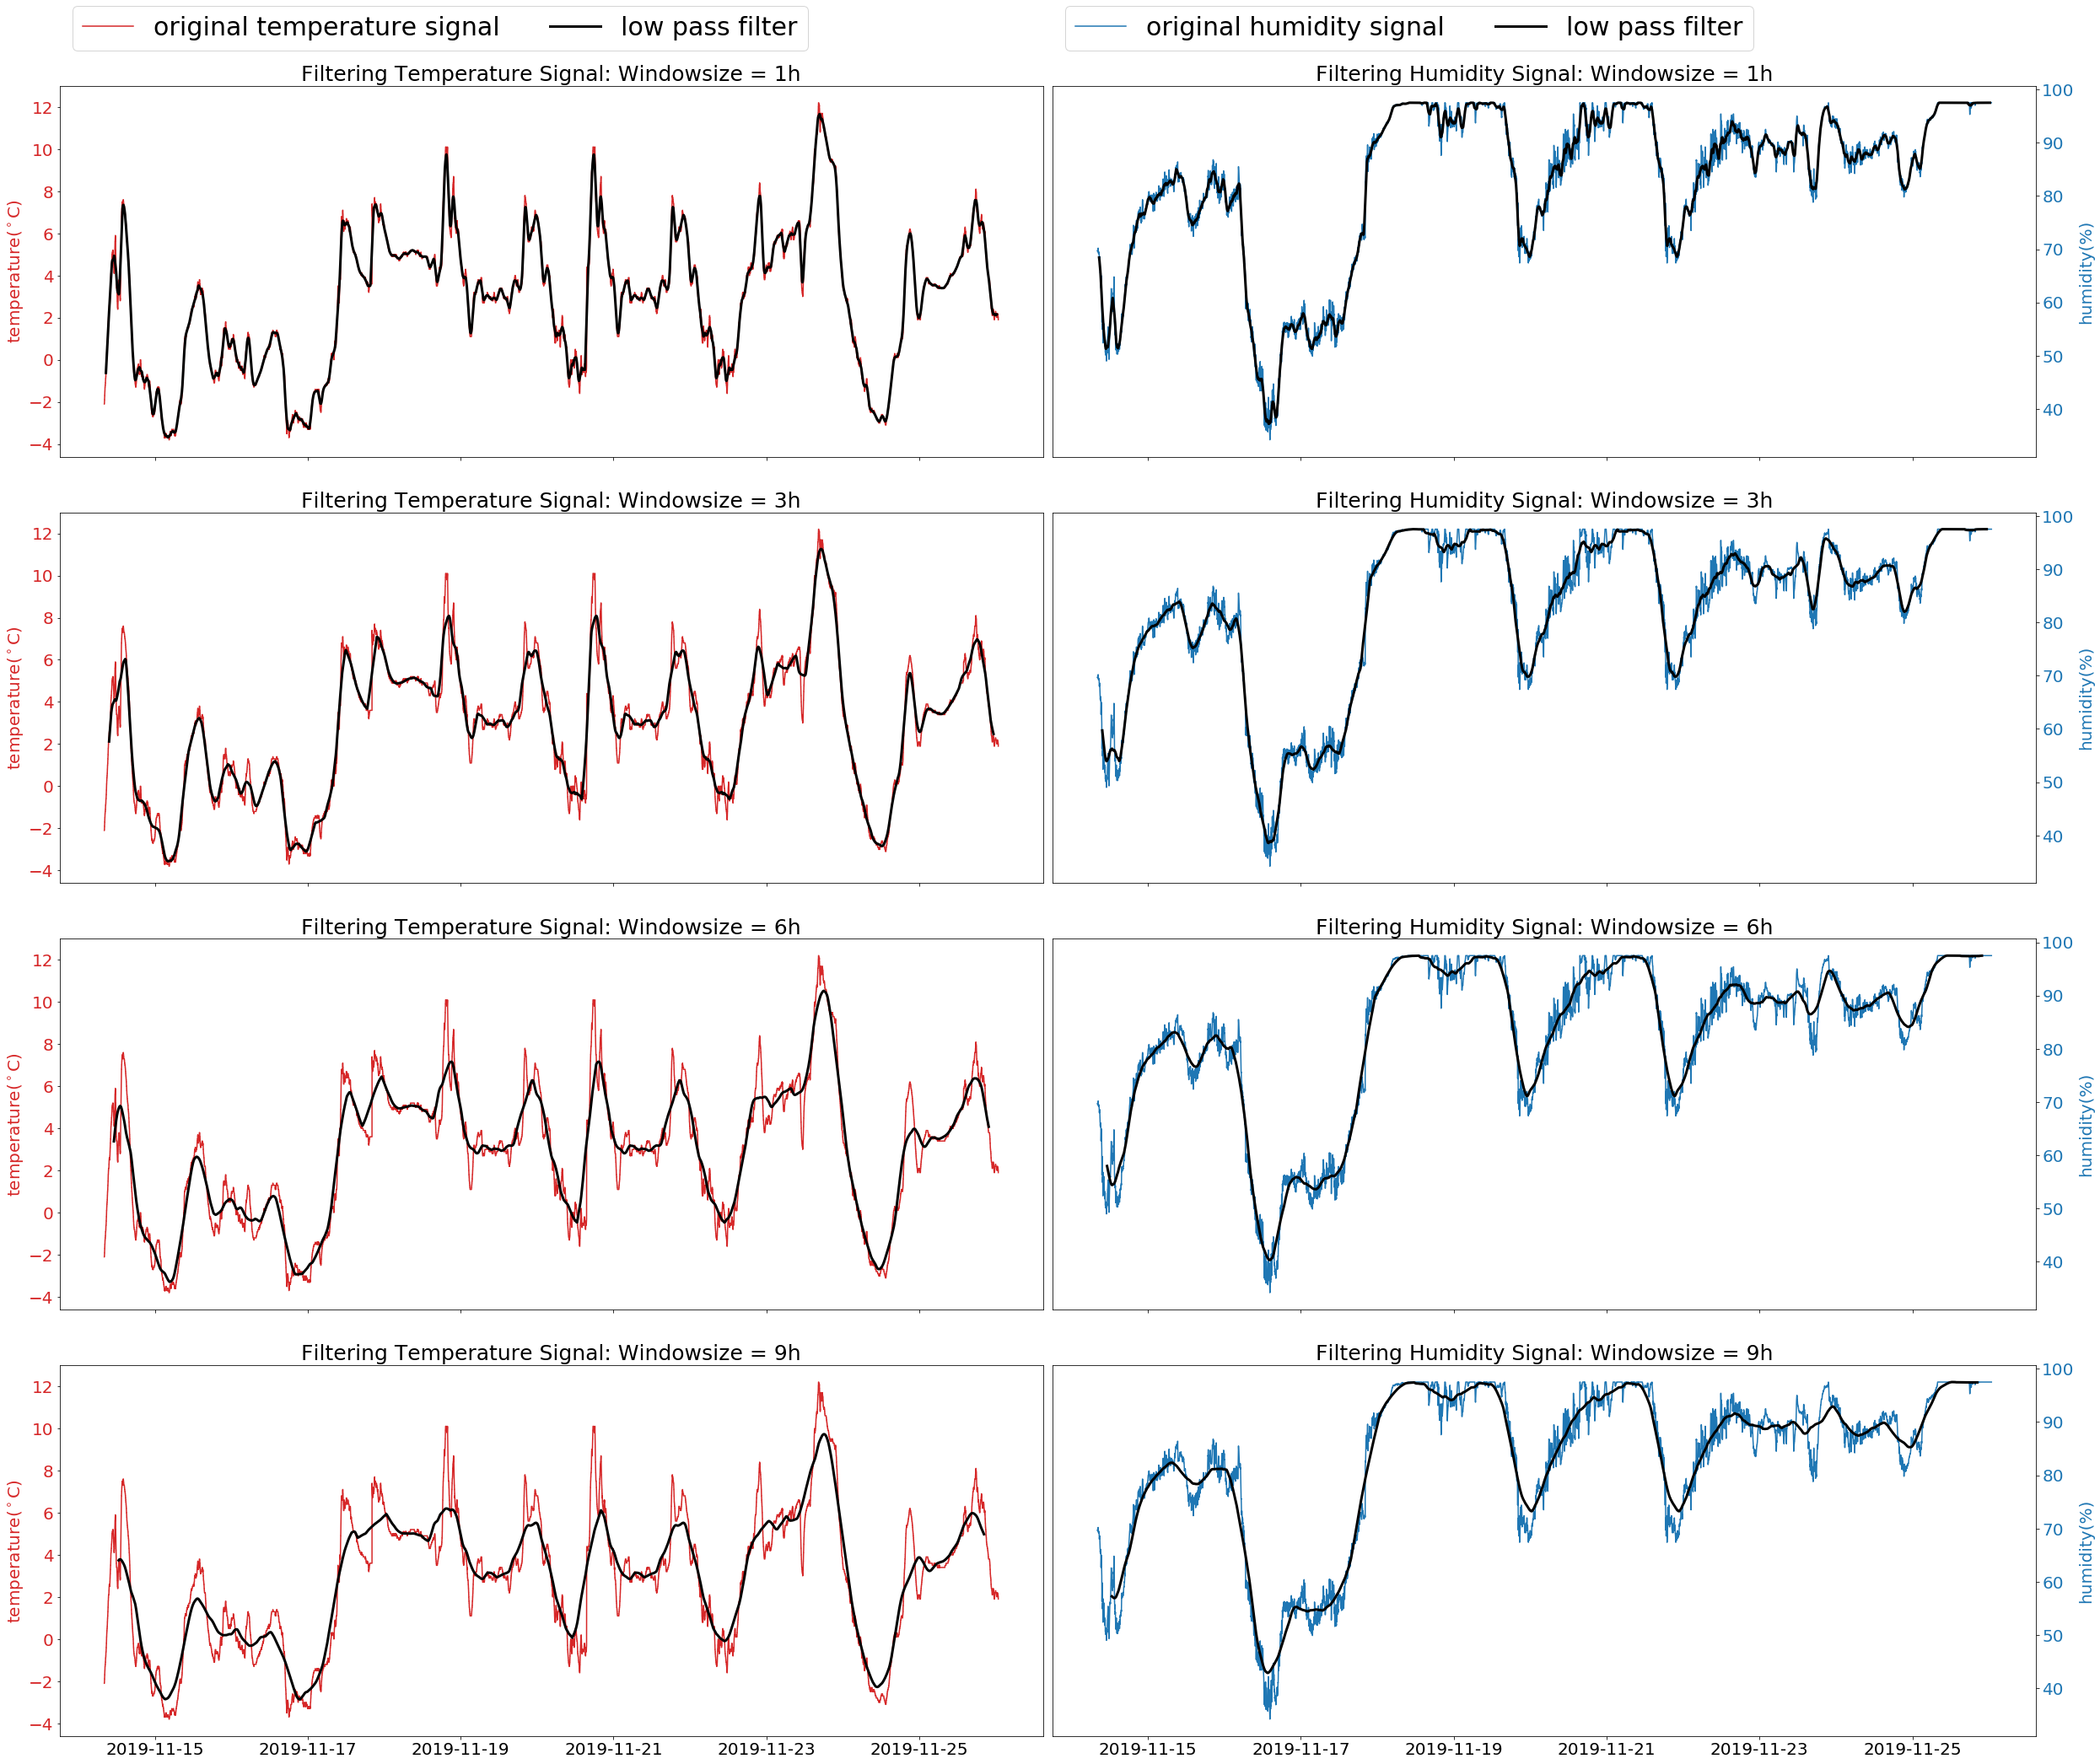

In [6]:
windowsize = [120,360,720,1080]
windowtime = ['1h', '3h', '6h', '9h']

originalsignal_temprature = data['temperature']
originalsignal_humidity = data['humidity']

fig, ax = plt.subplots(nrows=4,ncols=2,sharex= True,figsize=(42,36))

for i in range(len(windowsize)):
    lowPassFilteredsignal_temperature = originalsignal_temprature.rolling(windowsize[i], center=True).mean()
    lowPassFilteredsignal_humidity = originalsignal_humidity.rolling(windowsize[i], center=True).mean()

    ax[i, 0].plot(data.index,originalsignal_temprature,c='tab:red', label='original temperature signal')
    ax[i, 0].plot(data.index,lowPassFilteredsignal_temperature,c='k', linewidth=3, label='low pass filter')
    ax[i, 0].tick_params(axis='x', labelsize=20)
    ax[i, 0].tick_params(axis='y', labelsize=20, labelcolor='tab:red')
    ax[i, 0].set_ylabel("temperature($^\circ$C)", fontsize=20, color='tab:red')
    ax[i, 0].set_title("Filtering Temperature Signal: Windowsize = %s" % (windowtime[i]), size=25)

    
    ax[i, 1].plot(data.index,originalsignal_humidity,c='tab:blue', label='original humidity signal')
    ax[i, 1].plot(data.index,lowPassFilteredsignal_humidity,c='k', linewidth=3, label='low pass filter')
    ax[i, 1].yaxis.tick_right()
    ax[i, 1].yaxis.set_label_position("right")
    ax[i, 1].tick_params(axis='x', labelsize=20)
    ax[i, 1].tick_params(axis='y', labelsize=20, labelcolor='tab:blue')
    ax[i, 1].set_ylabel("humidity(%)", fontsize=20, color='tab:blue')
    ax[i, 1].set_title("Filtering Humidity Signal: Windowsize = %s" % (windowtime[i]), size=25)

ax[0, 0].legend(fontsize=30, loc='upper left', bbox_to_anchor=(0,1.25), ncol=2)
ax[0, 1].legend(fontsize=30, loc='upper left', bbox_to_anchor=(0,1.25), ncol=2)
plt.subplots_adjust(wspace=0.01, hspace=0.15)
plt.show()

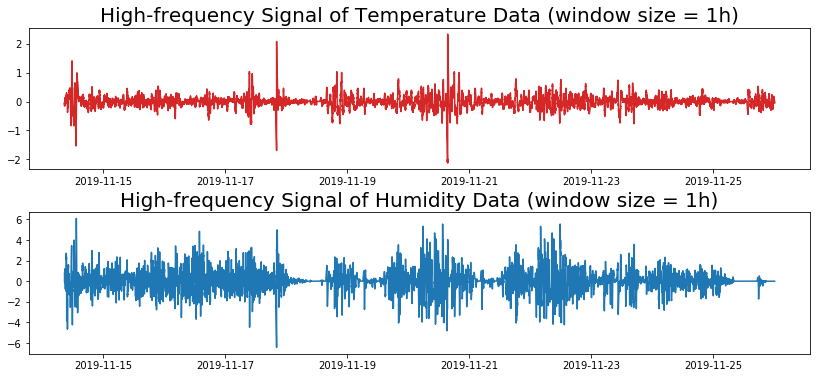

In [7]:
lowfreq_temperature_1h = originalsignal_temprature.rolling(120, center=True).mean()
lowfreq_humidity_1h = originalsignal_humidity.rolling(120, center=True).mean()

highfreq_temperature_1h = originalsignal_temprature - lowfreq_temperature_1h
highfreq_humidity_1h = originalSignal_humi - lowfreq_humidity_1h

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(14,6))
ax[0].plot(data.index,highfreq_temperature_1h,c='tab:red')
ax[0].set_title('High-frequency Signal of Temperature Data (window size = 1h)',fontsize=20)
ax[1].plot(data.index,highfreq_humidity_1h,c='tab:blue')
ax[1].set_title('High-frequency Signal of Humidity Data (window size = 1h)',fontsize=20)
plt.subplots_adjust(hspace=0.3)
plt.show()

Correlation coefficienct between high-frequency & low-frequency signals of temperature (when window size = 1 hour)

In [8]:
pd.DataFrame(np.array((highfreq_temperature_1h, lowfreq_temperature_1h)).reshape(len(data), 2), columns=["highfreq_temperature", "lowfreq_temperature"]).dropna().corr()

,highfreq_temperature,lowfreq_temperature
highfreq_temperature,1.00000,0.99995
lowfreq_temperature,0.99995,1.00000


# Forier Transformation to Temperature & Relative Humidity Data

In [9]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq

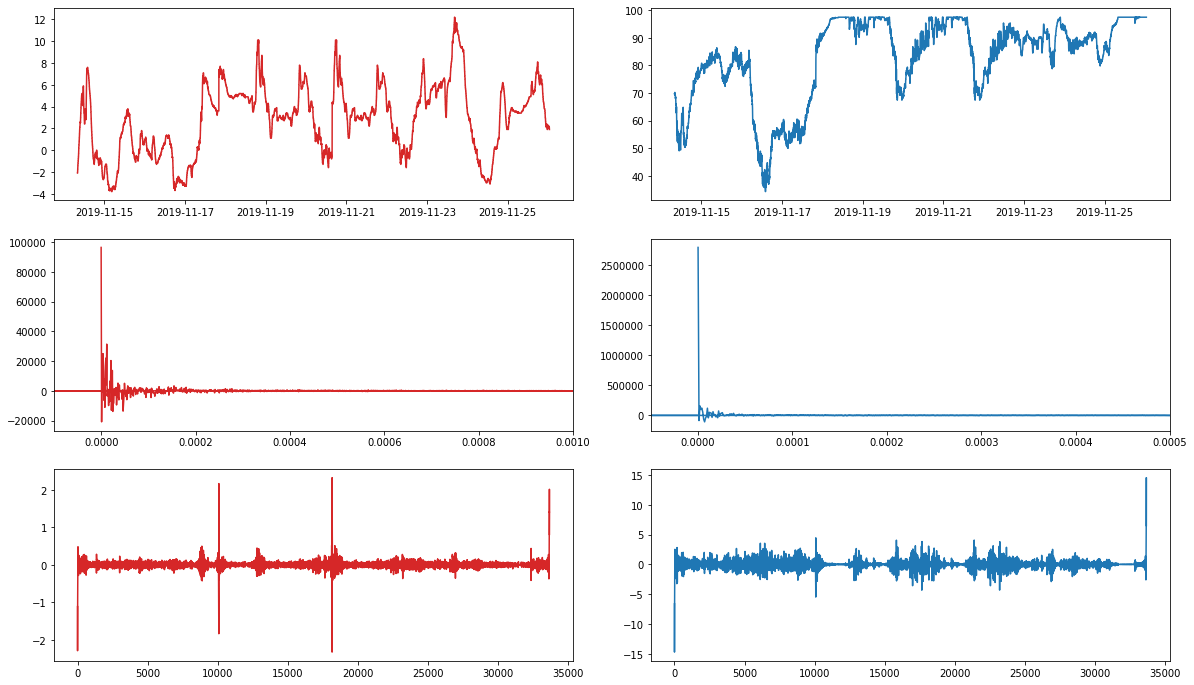

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

time = np.arange(len(data))

signal_temp = originalsignal_temprature
signal_humi = originalsignal_humidity
ax[0,0].plot(signal_temp, color='tab:red')
ax[0,1].plot(signal_humi, color='tab:blue')

W_temp = fftfreq(signal_temp.size, d=time[1]-time[0]) / 30
W_humi = fftfreq(signal_humi.size, d=time[1]-time[0]) / 30
f_signal_temp = rfft(signal_temp)
f_signal_humi = rfft(signal_humi)
ax[1,0].plot(W_temp,f_signal_temp, color='tab:red')
ax[1,1].plot(W_humi,f_signal_humi, color='tab:blue')
ax[1,0].set_xlim((-0.0001,0.001))
ax[1,1].set_xlim((-0.00005,0.0005))

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal_temp = f_signal_temp.copy()
cut_f_signal_temp[(W_temp<0.001)] = 0
cut_f_signal_humi = f_signal_humi.copy()
cut_f_signal_humi[(W_humi<0.001)] = 0

cut_signal_temp = irfft(cut_f_signal_temp)
cut_signal_humi = irfft(cut_f_signal_humi)
ax[2,0].plot(cut_signal_temp, color='tab:red')
ax[2,1].plot(cut_signal_humi, color='tab:blue')

plt.subplots_adjust(hspace=0.2, wspace=0.15)

# Correlation Analysis

Table of correlation coefficients

In [11]:
data.corr()

,temperature,humidity,soil_moisture_0,soil_moisture_1,soil_moisture_2
temperature,1.000000,0.315559,0.323092,0.304364,0.151697
humidity,0.315559,1.000000,0.356080,0.603979,0.245610
soil_moisture_0,0.323092,0.356080,1.000000,0.158352,0.049214
soil_moisture_1,0.304364,0.603979,0.158352,1.000000,0.098897
soil_moisture_2,0.151697,0.245610,0.049214,0.098897,1.000000


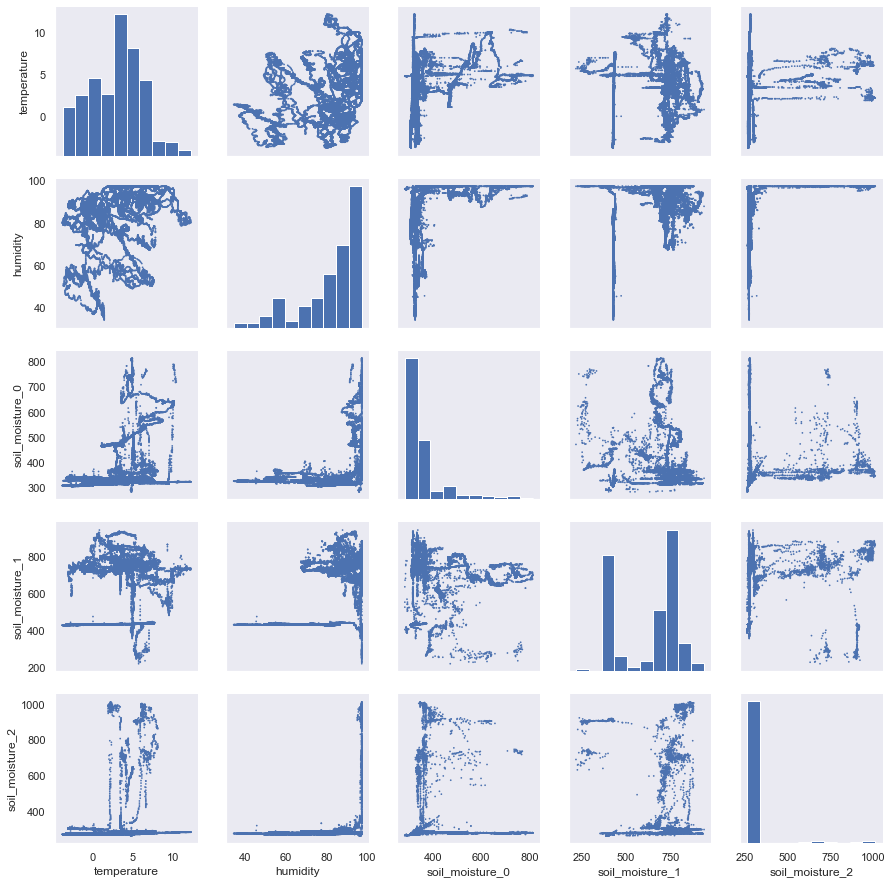

In [12]:
import seaborn as sns; sns.set(style="dark", color_codes=True)
g = sns.pairplot(data, plot_kws=dict(s=3, edgecolor="none"))

# Regression Analysis

## Generalized Linear Regression

In [13]:
import statsmodels.api as sm

Y = data['temperature']
X = data[['humidity', 'soil_moisture_0', 'soil_moisture_1', 'soil_moisture_2']]

X = sm.add_constant(X)

GLR = sm.OLS(Y, X).fit()
predictions = GLR.predict(X) 

print_model = GLR.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1919.
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:                -83638.
No. Observations:               33681   AIC:                         1.673e+05
Df Residuals:                   33676   BIC:                         1.673e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.2934      0.100    -

C:\Users\chong\Anaconda3\envs\cdi\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Polynomial Regression

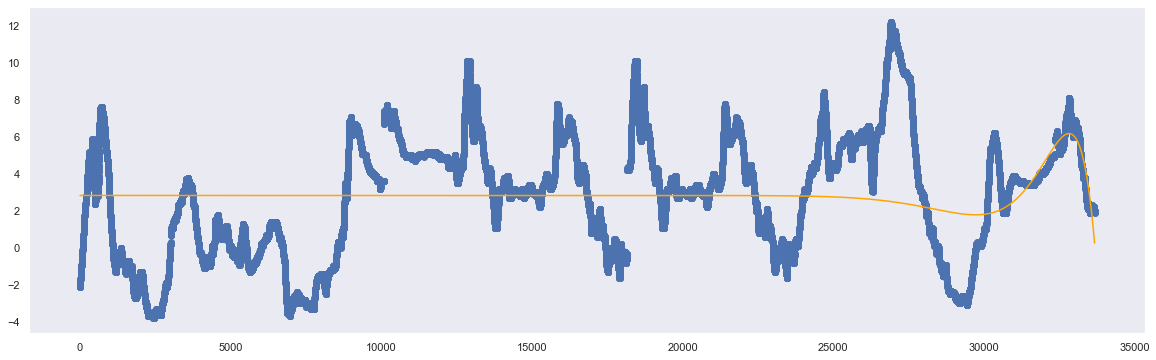

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(30),
                           LinearRegression())

x = np.arange(len(data))
y = data.temperature

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(x[:, np.newaxis])

fig, ax = plt.subplots(figsize=(20,6))
plt.scatter(x, y)
plt.plot(x, yfit, color='orange');

## Gaussian Regression

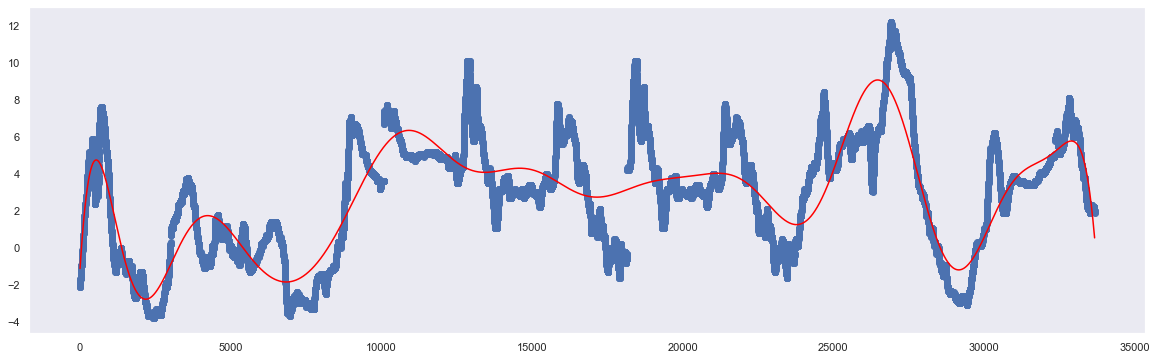

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(x[:, np.newaxis])

fig, ax = plt.subplots(figsize=(20,6))
plt.scatter(x, y)
plt.plot(x, yfit, color='red')

# The Numeric Model for the Water Equilibrium of Substrate Layer in Rain Garden

This model mainly estimates the equilibrium of water volumn contained by several inches (measuring depth is restricted by the probe length of our soil moisture sensor) of the soil substrate layer in Rain Garden. Theoretically, at each time point, the water volumn in the substrate layer is equal to the volumn of incoming water (mainly contributed by rainfall) subtracted by:
- volumn of water infiltration
- volumn of water runoff
- volumn of plant water uptake
- water evaporation

Hence, the relationship involving all these variables could be formularized as below:

\begin{equation}
    \frac{\partial{V_{water}}}{\partial t} = \frac{\partial{V_{water\_input}}}{\partial t} - \frac{\partial{V_{water\_infiltration}}}{\partial t} - \frac{\partial{V_{water\_runoff}}}{\partial t} - \frac{\partial{V_{plant\_uptake}}}{\partial t}- \frac{\partial{V_{evaporation}}}{\partial t}
\end{equation}

Several terms could modified in order to simplify the model because:

- No water runoff was observed on rainy days during field observation and therefore water runoff term is considered as constant 0.
- During the soil moisture sensor calibration process, we still observed no water runoff even though a large amount of water was poured to a small localized site (where a soil moisture sensor was buried) to make sure the soil was sufficiently saturated. Since water evaporation is a relatively slow process, we hypothesize that the substrate layer is effective in water infiltration and this term can not be ignored.
- On the other hand, it is also tedious to estimate the effectiveness of plant water uptake and  using the current data we have.

In sum, water infiltration and plant water uptake will be conbined with substrate water content (<span style='font-family:"Times New Roman"'> <span styel=''>\textit{soil_water_content}<span style='font-family:sans-serif'> <span styel=''>) and therefore moved to the left side of the model equation for simplification:

\begin{equation}
    \frac{\partial{V_{water}}}{\partial t} + \frac{\partial{V_{water\_infiltration}}}{\partial t} + \frac{\partial{V_{plant\_uptake}}}{\partial t}= \frac{\partial{V_{water\_input}}}{\partial t} - \frac{\partial{V_{evaporation}}}{\partial t}
\end{equation}

\begin{equation}
    \frac{\partial{V_{water+infiltration+uptake}}}{\partial t}= \frac{\partial{V_{water\_input}}}{\partial t} - \frac{\partial{V_{evaporation}}}{\partial t}
\end{equation}

\begin{equation}
    \frac{\partial{V_{soil\_water\_content}}}{\partial t}= \frac{\partial{V_{water\_input}}}{\partial t} - \frac{\partial{V_{evaporation}}}{\partial t}
\end{equation}

The two terms on the right side of equation (4) can be extended respectively:

- The total volumn of incoming water at certain depth of substrate layer is equal to the area of rain garden times the depth (to which soil moisture sensors could reach) offset by soil porosity:

\begin{equation}
    V_{soil\_water\_content} = S_{RG} \times Depth \times Porosity \times Soil_moisture
\end{equation}

where \textit{S<sub>RG</sub>} denotes the total area of Rain Garden.

The Saturation Vapor Pressure (SVP) is a variable related to air temperature can be calculated as follows:

\begin{equation}
    SVP = 610.7 \times 10^{\frac{7.5 \times temperature}{temperature + 237.3}}
\end{equation}

In addition, Vapor Pressure Deficit (VPD) that is dependent on both air temperature and humidity can be calculated as:

\begin{equation}
    VPD = (1-\frac{humidity}{100}) \times \frac{SVP}{1000}
\end{equation}

Finally, the evaporation effects can be formulated as a variable related to VPD:

\begin{equation}
    Evaporation = VPD \times S_{RG} \times \frac{1}{1000\times60\times2\times24}
\end{equation}

# Model Construction & Execution

The derivation process of the model for computing predicted soil water volumn:

\begin{equation}
    \frac{\partial{V_{soil\_water\_content}}}{\partial{t}} = \frac{\partial{V_{water\_input}}}{\partial{t}} + Evaporation
\end{equation}

Assume there are two time points:

\begin{equation*}
    t, t+\Delta{t}
\end{equation*}

Equation (9) can be written as:

\begin{equation}
    \frac{V_{soil\_water\_content(t+\Delta{t})} - {V_{soil\_water\_content(t)}}}{\Delta{t}} = \frac{V_{water\_input(t+\Delta{t})} - V_{water\_input(t)}}{\Delta{t}} + Evaporation
\end{equation}

Finally, the equation can be rewritten as:

\begin{equation}
    V_{soil\_water\_content(t+\Delta{t})} = V_{soil\_water\_content(t)} + (V_{water\_input(t+\Delta{t})} - V_{water\_input(t)}) + \Delta{t} \times Evaporation
\end{equation}

and equation (11) can be calculated by plugging in data and using programming language.

In [16]:
rg_area = 1.17 * 4046.86 # in meter
depth = 2.75 * 0.0254 # in meter
porosity = 0.25 #http://www.leesburgva.gov/home/showdocument?id=5057

data_m = data.copy()
data_m['soil_water_content_delta'], data_m['soil_water_content_pred'] = [0, 0]
data_m.head()

,temperature,humidity,soil_moisture_0,soil_moisture_1,soil_moisture_2,soil_water_content_delta,soil_water_content_pred
2019-11-14 08:09:00,-2.1,69.7,318,429,268,0,0
2019-11-14 08:09:30,-2.1,69.6,315,430,268,0,0
2019-11-14 08:10:00,-2.1,69.6,313,431,268,0,0
2019-11-14 08:10:30,-2.1,69.7,327,430,268,0,0
2019-11-14 08:11:00,-2.0,69.7,328,430,268,0,0


In [17]:
t = data_m.index[0]
delta_t = timedelta(seconds = 30) # in second
water_previous = data_m.loc[t, 'soil_water_content_pred']

while t + delta_t in data_m.index:
    soil_moisture_avg_next = (data_m.loc[t + delta_t, 'soil_moisture_1'] + data_m.loc[t + delta_t, 'soil_moisture_2']) / 2
    soil_moisture_avg = (data_m.loc[t, 'soil_moisture_1'] + data_m.loc[t, 'soil_moisture_2']) / 2
    delta_water_in = rg_area * depth * porosity * (soil_moisture_avg_next - soil_moisture_avg)
    
    SVP = 610.7 * 10 ** (7.5 * data_m.loc[t, 'temperature'] / (data_m.loc[t, 'temperature'] + 237.3))
    VPD = (1 - data_m.loc[t, 'humidity'] / 100) * SVP / 1000
    evaporation = VPD * rg_area / 1000 / (60 * 2 * 24)
    
    water_next = water_previous + delta_water_in + evaporation * delta_t.seconds
    water_previous = water_next
    t += delta_t
    
    data_m.loc[t, 'soil_water_content_delta'] = delta_water_in
    data_m.loc[t, 'soil_water_content_pred'] = water_next

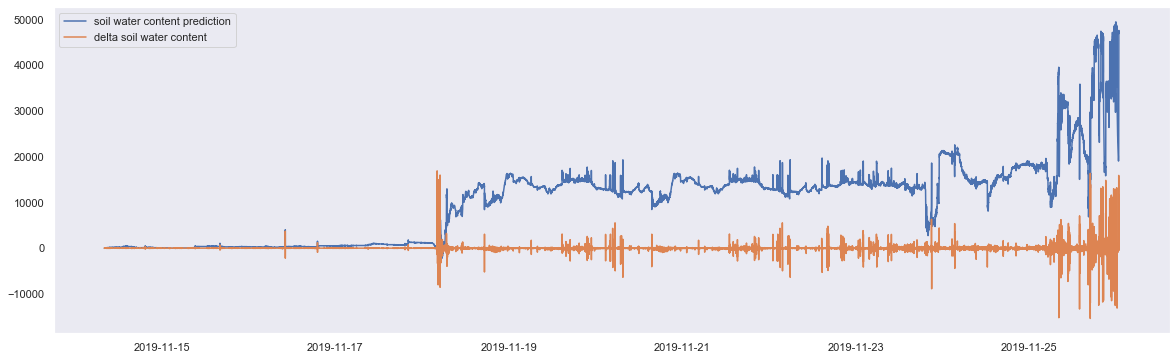

In [18]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_m.index, data_m.soil_water_content_pred, label='soil water content prediction')
ax.plot(data_m.index, data_m.soil_water_content_delta, label='delta soil water content')
ax.legend()
plt.show()